In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os
import urllib.request as urlreq
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.color import label2rgb
import json
import sklearn.mixture
import pickle as pkl
import torch
!cd patchmatch && make
from patchmatch import patch_match
from PIL import Image
from matplotlib.colors import ListedColormap

make: Nothing to be done for `all'.


objc[55133]: Class CaptureDelegate is implemented in both /Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x1573e6458) and /opt/homebrew/Cellar/opencv/4.8.1_4/lib/libopencv_videoio.4.8.1.dylib (0x29f158880). One of the two will be used. Which one is undefined.
objc[55133]: Class CVWindow is implemented in both /Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x1573e64a8) and /opt/homebrew/Cellar/opencv/4.8.1_4/lib/libopencv_highgui.4.8.1.dylib (0x28f3a8b38). One of the two will be used. Which one is undefined.
objc[55133]: Class CVView is implemented in both /Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x1573e64d0) and /opt/homebrew/Cellar/opencv/4.8.1_4/lib/libopencv_highgui.4.8.1.dylib (0x28f3a8b60). One of the two will be used. Which one is undefined.
objc[55133]: Class CVSlider is implemented in both /Users/isaac/miniforge3/envs/pytorc

In [2]:
uv_path = "uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

with open("triangulation.pkl", "rb") as f:
    triangles = pkl.load(f)

def update_readme():
    with open("README.md", "r") as f:
        lines = f.readlines()
    classical_header_index = lines.index("## Classical Approach\n")
    deeplearning_header_index = lines.index("## Deep Learning Approach\n")

    classical_figure_lines = []
    # add a line for each figure in /figures in alphabetical order
    for figure_name in sorted(os.listdir("figures")):
        classical_figure_lines.append(f"![](figures/{figure_name})\n")

    # replace the lines between the classical and deep learning headers with the new lines
    lines[classical_header_index+1:deeplearning_header_index] = classical_figure_lines
    # write the new lines to the README.md file
    with open("README.md", "w") as f:
        f.writelines(lines)


def display_images(images, save_name=None):
    # display images as a row of subfigures
    plt.figure(figsize=(2.5 * len(images), 2.5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(os.path.join("figures", save_name + ".png"))

def detect_face(image):
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"
    # chech if file is in working directory
    if not (haarcascade in os.listdir(os.curdir)):
        urlreq.urlretrieve(haarcascade_url, haarcascade)
    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    if len(faces) > 0:
        return faces[0]
    else:
        return np.array([0, image.shape[1], 0, image.shape[0]])

def display_bounding_boxes(images, bounding_boxes):
    image_templates = [image.copy() for image in images]
    for i, bounding_box in enumerate(bounding_boxes):
        (x,y,w,d) = bounding_box
        cv2.rectangle(image_templates[i],(x,y),(x+w, y+d),(255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks(image, bounding_box):
    # save facial landmark detection model's url in LBFmodel_url variable
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "LFBmodel.yaml"
    # check if file is in working directory
    if not (LBFmodel in os.listdir(os.curdir)):
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)
    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.array([bounding_box]))
    if len(landmarks) > 0:
        return landmarks[0]
    else:
        return np.zeros((68, 2))

def display_landmarks(images, landmarks):
    image_templates = [image.copy() for image in images]
    for i, landmark_set in enumerate(landmarks):
        for landmark in landmark_set[0]:
            x, y = landmark
            cv2.circle(image_templates[i], (int(x), int(y)), 1, (255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks_3D(image):
    NUM_FACE = 1
    mpFaceMesh = mp.solutions.face_mesh
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=NUM_FACE)
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(imgRGB)
    if results.multi_face_landmarks:
        return results.multi_face_landmarks[0]
    else:
        return None
    
def convert_landmarks_to_2D(landmarks_3D):
    return np.array([(point.x, point.y) for point in landmarks_3D.landmark[0:468]])
    
def display_landmarks_3D(images, landmarkss, save_name=None):
    img_templates = [image.copy() for image in images]
    for i, landmarks in enumerate(landmarkss):
        mpDraw = mp.solutions.drawing_utils
        drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)
        img = img_templates[i]
        mpFaceMesh = mp.solutions.face_mesh
        mpDraw.draw_landmarks(img, landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)
        for id,lm in enumerate(landmarks.landmark):
            ih, iw, ic = img.shape
            x,y = int(lm.x*iw), int(lm.y*ih)
    display_images(img_templates, save_name=save_name)

def detect_edges(image):
    # blur the image
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    # apply canny edge detection algorithm on the image
    return cv2.Canny(blurred_image, 25, 100)

def unwrap_face(image, landmarks):
    H_new,W_new = image.shape[0],image.shape[1]
    keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
    keypoints = np.array([(W_new*point.x,H_new*point.y) for point in landmarks.landmark[0:468]])

    tform = PiecewiseAffineTransform()
    tform.estimate(keypoints_uv, keypoints)
    texture = warp(image, tform, output_shape=(H_new,W_new))
    texture = (255*texture).astype(np.uint8)

    return texture

def discard_eyes_eyebrows_and_nostrils(image, points):
    global triangles
    triangles_to_discard = np.array([835, 760, 761, 757, 528, 527, 386, 387, 386, 387, 505, 506,
                        507, 535, 675, 771, 764, 763, 411, 412, 285, 286, 407, 406, 550, 551,
                        552, 684, 776, 777, 291, 294, 272, 547, 548, 543, 402, 253, 375, 376,
                        374, 249, 248, 373, 588, 589, 486, 342, 485, 587, 717, 716, 718,
                        720, 721, 613, 387, 386, 719, 714, 846, 845, 606, 605, 311, 312, 223,
                        224, 119, 109, 221, 350, 491, 809, 808, 728, 804, 803, 819, 818, 724,
                        844, 852, 888, 890, 889, 891,802, 469, 470, 467, 118, 640, 641, 638,
                        639, 637, 810, 821, 820, 811, 870, 869, 868, 854, 897, 896, 894, 895,
                        864, 865, 863, 862, 817, 646, 896, 866, 867, 861, 860, 859, 856, 860,
                        855, 816, 857, 858, 815, 816, 730, 729, 812, 813, 814, 629, 630, 643,
                        642, 629, 30, 120, 159, 158, 468, 466, 471, 604, 800, 801, 850, 885, 882,
                        883, 851, 879, 878, 877, 881, 880, 715, 884, 886, 156, 157, 230, 229,
                        227, 226, 635, 353, 636, 722, 723, 731, 732, 631, 632, 733, 735, 876,
                        875, 874, 873, 871, 872, 822, 824, 853, 893, 892, 734, 807, 806, 805,
                        887, 602, 603, 464, 465, 313, 228, 815, 816, 860, 629, 896])
    # find pixels within the triangles
    mask = np.ones(image.shape[:2], dtype=bool)
    for triangle_index in triangles_to_discard:
        triangle = points[triangles[triangle_index]][:, ::-1] * np.array([image.shape[1], image.shape[0]])
        # if triangle[:, 0].max() > 125 and triangle[:, 0].max() < 150:
        #     print(triangle_index)
        mask = mask ^ skimage.draw.polygon2mask(image.shape[:2], triangle)
    return image * mask[:, :, np.newaxis]
        
def identify_shadow_distribution(unwrapped_face):
    # Get non-black pixels.
    face_pixels = unwrapped_face.reshape(-1, 3)
    face_pixels = face_pixels[np.sum(face_pixels, axis=1) > 0]
    lab_face_pixels = skimage.color.rgb2lab(face_pixels.reshape(1, -1, 3)).reshape(-1, 3)
    # Fit a Gaussian mixture model.
    gmm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type="diag")
    gmm.fit(lab_face_pixels)
    return gmm

def generate_shadow_probability(unwrapped_face, model):
    face_pixels = unwrapped_face.reshape(-1, 3)
    face_pixels = face_pixels[np.sum(face_pixels, axis=1) > 0]
    lab_face_pixels = skimage.color.rgb2lab(face_pixels.reshape(1, -1, 3)).reshape(-1, 3)
    gmm = model
    probabilities = gmm.predict_proba(lab_face_pixels)[:, 0]
    predictions = probabilities > 0.5
    if np.mean(face_pixels[predictions == 0], axis=0)[0] < np.mean(face_pixels[predictions == 1], axis=0)[0]:
        probabilities = 1 - probabilities
    mask = np.zeros(unwrapped_face.shape[:2])
    mask[np.sum(unwrapped_face, axis=2) > 0] = probabilities
    mask[np.sum(unwrapped_face, axis=2) <= 0] = -1
    return mask

def generate_imputed_mean_color(unwrapped_face, shadow_probability):
    shadow_mask = (shadow_probability < 0.5).astype(np.uint8)
    shadow_mask_dilated = cv2.erode(shadow_mask, np.ones((11, 11), np.uint8), iterations=1)
    data = unwrapped_face * shadow_mask_dilated[:,:,np.newaxis]
    # create 256x256x2 array of xy coordinates
    xy = np.dstack(np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0])))
    # add as channels of data
    data = np.dstack([xy, data])
    data = data.reshape(-1, 5).astype(np.float32)
    mask = data[:, -3:].sum(axis=1) == 0
    poly = sklearn.preprocessing.PolynomialFeatures(1)
    X_train = poly.fit_transform(data[~mask, :-3])
    X_test = poly.transform(data[mask, :-3])
    data[mask, -3:] = sklearn.linear_model.LinearRegression().fit(X_train, data[~mask, -3:]).predict(X_test)

    imputed = data.reshape(256, 256, 5)[:,:,-3:]
    existing_pixels = unwrapped_face * shadow_mask[:,:,np.newaxis]
    add_mask = np.dstack([imputed.sum(axis=2) > existing_pixels.sum(axis=2)]*3)
    color = (imputed * add_mask + existing_pixels * (1 - add_mask)).clip(0,255).astype(np.uint8)
    color = cv2.medianBlur(color, 29)
    return color

def remove_shadow_naive(source, mean_color_map, shadow_probability, uniform=False):
    target_means = mean_color_map
    source_means = cv2.medianBlur(source, 29)
    shadow_mask = shadow_probability > 0.5
    if uniform:
        shadow_mask = np.ones(source.shape[:2]).astype(np.uint8)
    
    adjustment_factor = ((target_means).astype(np.float32) / (source_means).astype(np.float32))
    adjustment_factor[source.sum(axis=2) == 0] = 1
    adjustment_factor = np.dstack([shadow_mask]*3) * (adjustment_factor - 1)
    adjustment_factor = cv2.GaussianBlur((adjustment_factor * 255).clip(0, 255).astype(np.uint8), (3, 3), 1) / 255
    unshadowed_face = (source * (1 + adjustment_factor)).clip(0, 255).astype(np.uint8)
    return unshadowed_face

def wrap_face(unwrapped_face, landmarks):
    H_new,W_new = unwrapped_face.shape[0],unwrapped_face.shape[1]
    keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
    keypoints = np.array([(W_new*point.x,H_new*point.y) for point in landmarks.landmark[0:468]])

    tform = PiecewiseAffineTransform()
    tform.estimate(keypoints, keypoints_uv)
    wrapped = warp(unwrapped_face, tform, output_shape=(H_new,W_new))
    wrapped = (255*wrapped).astype(np.uint8)

    return wrapped

def blend_seamless(original_image, rewrapped_face, landmarks):
    noise = (np.random.normal(0, 1, rewrapped_face.shape) * 5).clip(0, 255).astype(np.uint8)
    noisy_rewrapped_face = (rewrapped_face.astype(int) + noise.astype(int)).clip(0, 255).astype(np.uint8)
    alpha = (rewrapped_face.sum(2) > 0).astype(np.uint8) * 255

    noisy_rewrapped_face = noisy_rewrapped_face.astype(int) + (original_image * ((255 - alpha[:,:,np.newaxis]) / 255))
    noisy_rewrapped_face = noisy_rewrapped_face.clip(0, 255).astype(np.uint8)

    alpha = cv2.erode(alpha, np.ones((5, 5), np.uint8), iterations=1)

    alpha = cv2.GaussianBlur(alpha, (51, 51), 0, borderType=cv2.BORDER_REFLECT)
    alpha = alpha[:,:,np.newaxis]

    src_luminance = noisy_rewrapped_face.sum(2)
    dst_luminance = original_image.sum(2)
    alpha[dst_luminance > src_luminance] = 255

    highest_landmark = 1
    lowest_landmark = 0
    leftmost_landmark = 1
    rightmost_landmark = 0
    for landmark in convert_landmarks_to_2D(landmarks):
        if landmark[1] < highest_landmark:
            highest_landmark = landmark[1]
        if landmark[1] > lowest_landmark:
            lowest_landmark = landmark[1]
        if landmark[0] < leftmost_landmark:
            leftmost_landmark = landmark[0]
        if landmark[0] > rightmost_landmark:
            rightmost_landmark = landmark[0]

    center = (np.mean([highest_landmark, lowest_landmark]) * original_image.shape[0], np.mean([leftmost_landmark, rightmost_landmark]) * original_image.shape[1])
    center = (int(center[1]) - 1, int(center[0]) - 1)
    seamless_blend = cv2.seamlessClone(noisy_rewrapped_face, original_image, alpha, center, cv2.NORMAL_CLONE)
    return seamless_blend

def get_eye_mouth(image, landmarks_2d):
    global triangles
    triangles_to_include = np.array([835, 760, 761, 757, 528, 527, 386, 387, 386, 387, 505, 506,
                        507, 535, 675, 771, 764, 763, 411, 412, 285, 286, 407, 406, 550, 551,
                        552, 684, 776, 777, 291, 294, 272, 547, 548, 543, 402, 253, 375, 376,
                        374, 249, 248, 373, 588, 589, 486, 342, 485, 587, 717, 716, 718,
                        720, 721, 613, 387, 386, 719, 714, 846, 845, 606, 605, 311, 312, 223,
                        224, 119, 109, 221, 350, 491, 809, 808, 728, 804, 803, 819, 818, 724,
                        844, 852, 888, 890, 889, 891,802, 469, 470, 467, 118, 640, 641, 638,
                        639, 637, 810, 821, 820, 811, 870, 869, 868, 854, 897, 896, 894, 895,
                        864, 865, 863, 862, 817, 646, 896, 866, 867, 861, 860, 859, 856, 860,
                        855, 816, 857, 858, 815, 816, 730, 729, 812, 813, 814, 629, 630, 643,
                        642, 629, 30, 120, 159, 158, 468, 466, 471, 604, 800, 801, 850, 885, 882,
                        883, 851, 879, 878, 877, 881, 880, 715, 884, 886, 156, 157, 230, 229,
                        227, 226, 635, 353, 636, 722, 723, 731, 732, 631, 632, 733, 735, 876,
                        875, 874, 873, 871, 872, 822, 824, 853, 893, 892, 734, 807, 806, 805,
                        887, 602, 603, 464, 465, 313, 228, 815, 816, 860, 629, 896])
    # find pixels within the triangles
    mask = np.ones(image.shape[:2], dtype=bool)
    for triangle_index in triangles_to_include:
        triangle = landmarks_2d[triangles[triangle_index]][:, ::-1] * np.array([image.shape[1], image.shape[0]])
        mask = mask ^ skimage.draw.polygon2mask(image.shape[:2], triangle)
    return image * ~mask[:, :, np.newaxis]

def get_face_mask(face_image, landmarks_2d_unscaled):
    landmarks_2d = landmarks_2d_unscaled * np.array([face_image.shape[1], face_image.shape[0]])
    global triangles
    mask = np.ones((256, 256), dtype=bool)
    for triangle in triangles:
        mask = mask ^ skimage.draw.polygon2mask((256, 256), landmarks_2d[triangle][:, ::-1])
    return ~mask[:,:,np.newaxis]

def inpaint(image, mask, method="patchmatch", patch_size=4):
    if method == "patchmatch":
        result = patch_match.inpaint(image, (mask[:,:,np.newaxis] * 255).clip(0,255).astype(np.uint8), patch_size=patch_size)
    elif method == "telea":
        result = cv2.inpaint(image, (mask[:,:,np.newaxis] * 255).clip(0,255).astype(np.uint8), patch_size, cv2.INPAINT_TELEA)
    elif method == "ns":
        result = cv2.inpaint(image, (mask[:,:,np.newaxis] * 255).clip(0,255).astype(np.uint8), patch_size, cv2.INPAINT_NS)
    else:
        raise Exception("Invalid inpainting method")
    return result

def composite(background, foreground, mask=None, poisson=False):
    if mask is None:
        mask = np.ones(foreground.shape[:2], dtype=bool)
        mask[np.where(foreground.sum(axis=2) == 0)] = False
    if mask.ndim == 2:
        mask = mask[:,:,np.newaxis]
    if poisson:
        poisson_blended = np.zeros(background.shape, dtype=np.uint8)
        mask = mask.astype(np.uint8) * 255
        mask_min_x = np.min(np.where(mask.sum(axis=0) > 0)[0])
        mask_max_x = np.max(np.where(mask.sum(axis=0) > 0)[0])
        mask_min_y = np.min(np.where(mask.sum(axis=1) > 0)[0])
        mask_max_y = np.max(np.where(mask.sum(axis=1) > 0)[0])
        mask_center_x = (mask_min_x + mask_max_x) // 2
        mask_center_y = (mask_min_y + mask_max_y) // 2
        foreground = foreground.clip(0, 255).astype(np.uint8)
        background = background.clip(0, 255).astype(np.uint8)
        poisson_blended = cv2.seamlessClone(foreground, background, mask, (mask_center_x, mask_center_y), cv2.NORMAL_CLONE).clip(0, 255).astype(np.uint8)
        return poisson_blended
    else:
        no_poisson = (background * (1 - mask) + foreground * mask).clip(0, 255).astype(np.uint8)
        return no_poisson

def refine_mask(mask_):
    radius = 6
    mask = mask_.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def get_largest_connected_component(mask, ignore_mask=None):
    mask = mask.astype(np.uint8) * 255
    ignore_mask = ignore_mask.astype(np.uint8) * 255
    ignore_mask = cv2.dilate(ignore_mask, np.ones((3, 3), np.uint8), iterations=10)
    # if ignore_mask is not None:
    #     mask = mask * (255 - ignore_mask)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    largest_component_index = np.argmax(stats[1:, 4]) + 1
    largest_component_mask = (labels == largest_component_index).astype(np.uint8)
    return largest_component_mask

def sharpen(image, mask=None):
    if mask is None:
        mask = np.ones(image.shape[:2], dtype=bool)
    mask = mask[:,:,np.newaxis]
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return (image * (1 - mask) + sharpened * mask).clip(0, 255).astype(np.uint8)

def migrate_landmarks(landmarks_2d):
    forehead_landmarks = [10, 67, 103, 109, 297, 332, 338]
    max_y = landmarks_2d[:, 1].max()
    min_y = landmarks_2d[:, 1].min()
    face_height = max_y - min_y
    for point_index in forehead_landmarks:
        landmarks_2d[point_index, 1] -= face_height * 0.15
    return landmarks_2d

def ease_out(x):
    return (1 - (x - 1)**2)
ease_out_values = np.linspace(0, 1, 256)
ease_out_colors = np.column_stack([ease_out(ease_out_values), ease_out(ease_out_values), ease_out(ease_out_values)])
ease_out_cmap = ListedColormap(ease_out_colors)

def blend_forehead_mask(face_mask, landmarks_2d):
    global triangles
    landmarks = landmarks_2d
    migrated_landmarks = migrate_landmarks(landmarks)
    colors = np.ones(len(migrated_landmarks), dtype=np.uint8) * 1
    forehead_landmarks = [10, 67, 103, 109, 297, 332, 338]
    colors[forehead_landmarks] = 0
    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(face_mask[:,:,0], cmap="gray")
    plt.tricontour(migrated_landmarks[:,0] * 256, migrated_landmarks[:,1] * 256, colors, levels=256, cmap=ease_out_cmap)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("tmp.png", bbox_inches='tight', pad_inches=0)
    plt.clf()
    extended_face_mask = np.array(Image.fromarray(plt.imread("tmp.png")[:,:,0]).resize((256, 256)))
    return extended_face_mask

def blend_forehead(face_image, original_mask, unshadowed_unmasked_face_image, landmarks_2d):
    soft_mask = blend_forehead_mask(original_mask, landmarks_2d)
    soft_mask = soft_mask[:,:,np.newaxis]
    return composite(face_image, unshadowed_unmasked_face_image, mask=soft_mask, poisson=False) 

def pipeline(image):
    if type(image) != list:
        face_images = [image]
    else:
        face_images = image
    face_landmarks_3d = [detect_landmarks_3D(image) for image in face_images]
    for i in range(len(face_landmarks_3d)):
        if face_landmarks_3d[i] is None:
            if i == 0:
                for j in range(1, len(face_landmarks_3d)):
                    if face_landmarks_3d[j] is not None:
                        face_landmarks_3d[i] = face_landmarks_3d[j]
                        break
            else:
                face_landmarks_3d[i] = face_landmarks_3d[i-1]
    face_landmarks_2d = [convert_landmarks_to_2D(landmarks) for landmarks in face_landmarks_3d]
    # display_landmarks_3D(face_images, face_landmarks_3d, save_name="../../figures/classical_components/landmarks_3d")
    face_masks = [get_face_mask(face_image, landmarks) for face_image, landmarks in zip(face_images, face_landmarks_2d)]
    face_masks = [blend_forehead_mask(face_mask, landmarks)[:,:,np.newaxis] for face_mask, landmarks in zip(face_masks, face_landmarks_2d)]
    masked_face_images = [(face_image * mask).clip(0, 255).astype(np.uint8) for face_image, mask in zip(face_images, face_masks)]
    # display_images(masked_face_images, save_name="../../figures/classical_components/masked_face")
    unmasked_shadow_masks = [generate_shadow_probability(face_image, identify_shadow_distribution(masked_face_image)) > 0.5 for face_image, masked_face_image in zip(face_images, masked_face_images)]
    unmasked_shadow_masks = [refine_mask(shadow_mask) for shadow_mask in unmasked_shadow_masks]
    unmasked_ignore_masks = [get_eye_mouth(image, landmarks).sum(2) > 0 for image, landmarks in zip(face_images, face_landmarks_2d)]
    unmasked_shadow_masks = [get_largest_connected_component(shadow_mask, ignore_mask) for shadow_mask, ignore_mask in zip(unmasked_shadow_masks, unmasked_ignore_masks)]
    shadow_masks = [generate_shadow_probability(masked_face_image, identify_shadow_distribution(masked_face_image)) > 0.5 for masked_face_image in masked_face_images]
    # display_images(shadow_masks, save_name="../../figures/classical_components/shadow_mask")
    shadow_masks = [refine_mask(shadow_mask) for shadow_mask in shadow_masks]
    ignore_masks = [get_eye_mouth(image, landmarks).sum(2) > 0 for image, landmarks in zip(face_images, face_landmarks_2d)]
    shadow_masks = [get_largest_connected_component(shadow_mask, ignore_mask) for shadow_mask, ignore_mask in zip(shadow_masks, ignore_masks)]
    # display_images(shadow_masks, save_name="../../figures/classical_components/refined_shadow_mask")
    dilated_shadow_masks = [cv2.dilate(shadow_mask.astype(np.uint8), np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8), iterations=7) for shadow_mask in shadow_masks]
    dilation_diffs = [(dilated_shadow_mask - shadow_mask) * face_mask[:,:,0] for dilated_shadow_mask, shadow_mask, face_mask in zip(dilated_shadow_masks, shadow_masks, face_masks)]
    # display_images(dilation_diffs, save_name="../../figures/classical_components/boundary_mask")
    mean_color_maps = [generate_imputed_mean_color(masked_face_image, shadow_mask) for masked_face_image, shadow_mask in zip(masked_face_images, shadow_masks)]
    # display_images(mean_color_maps, save_name="../../figures/classical_components/color_map")
    unshadowed_unmasked_face_images = [remove_shadow_naive(face_image, mean_color_map, shadow_mask, uniform=False) for face_image, shadow_mask, mean_color_map in zip(face_images, unmasked_shadow_masks, mean_color_maps)]
    unshadowed_unmasked_face_images = [blend_forehead(face_images[i], face_masks[i], unshadowed_unmasked_face_images[i], face_landmarks_2d[i]) for i in range(len(face_images))]
    # display_images(unshadowed_unmasked_face_images, save_name="../../figures/classical_components/unshadowed_blended")
    composited = [((1 - mask) * face_image + mask * unshadowed_unmasked_face_image).clip(0,255).astype(np.uint8) for mask, face_image, unshadowed_unmasked_face_image in zip(face_masks, face_images, unshadowed_unmasked_face_images)]
    inpainting_masks = dilation_diffs
    inpaintings = [inpaint(composite, dilation_diff, method="patchmatch", patch_size=4) for composite, dilation_diff in zip(composited, dilation_diffs)]
    # display_images(inpaintings, save_name="../../figures/classical_components/inpainted")
    eyes_mouth_added_back = [composite(inpainted, get_eye_mouth(image, landmarks), poisson=True) for inpainted, image, landmarks in zip(inpaintings, face_images, face_landmarks_2d)]
    sharpening_masks = [(get_eye_mouth(image, landmarks).sum(2) + inpainting_mask) > 0 for image, landmarks, inpainting_mask in zip(eyes_mouth_added_back, face_landmarks_2d, inpainting_masks)]
    eyes_mouth_sharpened = [sharpen(image, mask) for image, mask in zip(eyes_mouth_added_back, sharpening_masks)]
    # display_images(eyes_mouth_sharpened, save_name="../../figures/classical_components/features_recomped")
    if type(image) != list:
        return eyes_mouth_sharpened[0]
    else:
        return eyes_mouth_sharpened

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_55133/2622175722.py:212: RuntimeWarning: divide by zero encountered in divide
  adjustment_factor = ((target_means).astype(np.float32) / (source_means).astype(np.float32))


<Figure size 640x480 with 0 Axes>

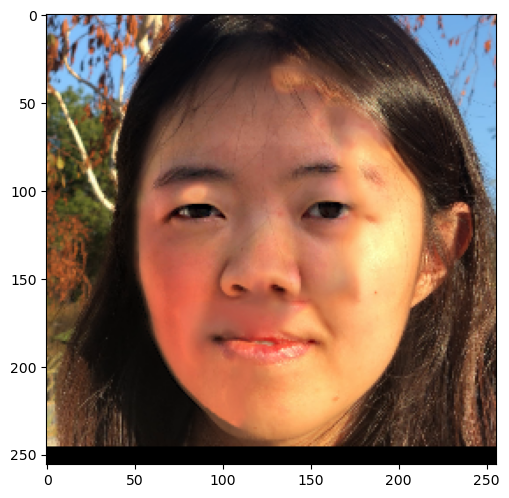

In [4]:
n = 1
all_images = [(plt.imread(os.path.join("../images", path)) * 255).astype(np.uint8) for path in sorted(os.listdir("../images")) if path.endswith(".png")][:n]
results = pipeline(all_images)
result_paths = [os.path.join("results", path) for path in sorted(os.listdir("../images")) if path.endswith(".png")][:n]
for path, result in zip(result_paths, results):
    plt.imshow(result)
    plt.imsave(path, result)